<a href="https://colab.research.google.com/github/cosimo-schiavoni/Massive_Data_Project/blob/main/Comics_Faces_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Check the connection to a GPU.

In [1]:
!nvidia-smi

Tue Sep 13 23:04:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Install the Kaggle package.

In [2]:
!pip install -q kaggle

Load the kaggle.json file in order to execute the download of the dataset. (Each user should upload his own file).

In [3]:
from google.colab import files

files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


Import required libraries.

In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras import optimizers, regularizers
from functools import reduce
import os
import zipfile
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
import pickle
import shutil
import random
import skimage.io as io
from copy import deepcopy
from kaggle.api.kaggle_api_extended import KaggleApi
from tensorflow.keras import layers
import numpy as np
from shutil import move
from os.path import join
import os
from google.colab import files
from shutil import copyfile

Download the dataset from a remote repository.

In [5]:
os.environ["data_source"] = "./Face_Comics_data"

api = KaggleApi()
api.authenticate()

if not os.path.exists(os.environ["data_source"]):
  os.makedirs(os.environ["data_source"])
  if "comic-faces-paired-synthetic-v2" not in os.listdir():
    if "comic-faces-paired-synthetic-v2.zip" not in os.listdir():
      ! kaggle datasets download -d defileroff/comic-faces-paired-synthetic-v2
      with zipfile.ZipFile("comic-faces-paired-synthetic-v2.zip", 'r') as f:
        f.extractall("comic-faces-paired-synthetic-v2")
    os.remove("comic-faces-paired-synthetic-v2.zip")


!mv "./comic-faces-paired-synthetic-v2/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/comics" "./Face_Comics_data"
!mv "./comic-faces-paired-synthetic-v2/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces" "./Face_Comics_data"

!rm -rf comic-faces-paired-synthetic-v2

 99% 2.16G/2.18G [00:18<00:00, 181MB/s]
100% 2.18G/2.18G [00:18<00:00, 129MB/s]


Create Directories for Train, Validation and Test sets

In [2]:
os.makedirs(os.path.join(os.environ["data_source"], 'train/comics'))
os.makedirs(os.path.join(os.environ["data_source"], 'train/faces'))
os.makedirs(os.path.join(os.environ["data_source"], 'validation/comics'))
os.makedirs(os.path.join(os.environ["data_source"], 'validation/faces'))
os.makedirs(os.path.join(os.environ["data_source"], 'test/comics'))
os.makedirs(os.path.join(os.environ["data_source"], 'test/faces'))

tmp_comics_dir = './Face_Comics_data/comics'
tmp_faces_dir = './Face_Comics_data/faces'
comics_test_dir = './Face_Comics_data/test/comics'
faces_test_dir = './Face_Comics_data/test/faces'
comics_validation_dir = './Face_Comics_data/validation/comics'
faces_validation_dir = './Face_Comics_data/validation/faces'
comics_train_dir = './Face_Comics_data/train/comics'
faces_train_dir = './Face_Comics_data/train/faces'
train_dir = './Face_Comics_data/train'
validation_dir = './Face_Comics_data/validation'
test_dir = './Face_Comics_data/test'

Define global variables

In [7]:
TRAIN_TEST_SPLIT_AT = 0.7
TRAIN_VALIDATION_SPLIT_AT = 0.7
BATCH_SIZE = 64
EPOCHS = 45
EXPERIMENT_SIZE = 10000

Split the original dataset into Train, Validation and Test sets.

In [3]:
#TEST - TRAINING SPLIT

list_of_comics_images = os.listdir('./Face_Comics_data/comics')
list_of_faces_images = os.listdir('./Face_Comics_data/faces')

np.random.shuffle(list_of_comics_images)
np.random.shuffle(list_of_faces_images)

c = 0
for i in list_of_comics_images:
    if c < (round(TRAIN_TEST_SPLIT_AT * EXPERIMENT_SIZE)):
      move(os.path.join(tmp_comics_dir, i), os.path.join(comics_train_dir, i))
      c += 1
    else:
      move(os.path.join(tmp_comics_dir, i), os.path.join(comics_test_dir, i))
      c += 1

c = 0
for i in list_of_faces_images:
    if c < (round(TRAIN_TEST_SPLIT_AT * EXPERIMENT_SIZE)):
      try:
        move(os.path.join(tmp_faces_dir, i), os.path.join(faces_train_dir, i))
        c += 1
      except:
        c+= 1
        next
    else:
      move(os.path.join(tmp_faces_dir, i), os.path.join(faces_test_dir, i))
      c += 1

TRAIN_SIZE = len(os.listdir(comics_train_dir))

#TRAINING - VALIDATION SPLIT

list_of_comics_images = os.listdir('./Face_Comics_data/train/comics')
list_of_faces_images = os.listdir('./Face_Comics_data/train/faces')

np.random.shuffle(list_of_comics_images)
np.random.shuffle(list_of_faces_images)

c = 0
for i in list_of_comics_images:
    if c < (round(TRAIN_VALIDATION_SPLIT_AT * TRAIN_SIZE)):
      c += 1
    else:
      move(os.path.join(comics_train_dir, i), os.path.join(comics_validation_dir, i))
      c += 1

c = 0
for i in list_of_faces_images:
    if c < (round(TRAIN_VALIDATION_SPLIT_AT * TRAIN_SIZE)):
      c += 1
    else:
      move(os.path.join(faces_train_dir, i), os.path.join(faces_validation_dir, i))
      c += 1

print('Total training images :', len(os.listdir(comics_train_dir)) + len(os.listdir(faces_train_dir)))
print('Total validation images :', len(os.listdir(comics_validation_dir)) + len(os.listdir(faces_validation_dir)))
print('Total test images :', len(os.listdir(comics_test_dir)) + len(os.listdir(faces_test_dir)))

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-0d3585c4161a>", line 43, in <module>
    if c < (round(TRAIN_VALIDATION_SPLIT_AT * TRAIN_SIZE)):
NameError: name 'TRAIN_VALIDATION_SPLIT_AT' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/

NameError: ignored

Define data augmentation functions to be implemented in the analysis.

In [4]:
#data augmentation

@tf.function
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (180-x)
  else:
    x
  return x

###Randim invert
@tf.function 
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

#@tf.function 
class RandomInvert(layers.Layer):
  @tf.function 
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor
  @tf.function 
  def call(self, x):
    return random_invert_img(x)


###Kernel Inizializer Sobel_x
@tf.function 
def hedge_detector(shape, dtype=None):
    print(shape)    
    sobel_x = tf.constant(
        [
            [-5, -4, 0, 4, 5], 
            [-8, -10, 0, 10, 8], 
            [-10, -20, 0, 20, 10], 
            [-8, -10, 0, 10, 8], 
            [-5, -4, 0, 4, 5]
        ], dtype=dtype )
    #create the missing dims.
    sobel_x = tf.reshape(sobel_x, (5, 5, 1, 1))

    print(tf.shape(sobel_x))
    #tile the last 2 axis to get the expected dims.
    sobel_x = tf.tile(sobel_x, (1, 1, shape[-2],shape[-1]))

    print(tf.shape(sobel_x))
    return sobel_x

@tf.function 
def vertical_detector(shape, dtype=None):
    print(shape)    
    sobel_x = tf.constant(
        [
            [1, 0, -1], 
            [1, 0, -1], 
            [1, 0, -1]
        ], dtype=dtype )
    #create the missing dims.
    sobel_x = tf.reshape(sobel_x, (3, 3, 1, 1))

    print(tf.shape(sobel_x))
    #tile the last 2 axis to get the expected dims.
    sobel_x = tf.tile(sobel_x, (1, 1, shape[-2],shape[-1]))

    print(tf.shape(sobel_x))
    return sobel_x

@tf.function 
def horizontal_detector(shape, dtype=None):
    print(shape)    
    sobel_x = tf.constant(
        [
            [1, 1, 1], 
            [0, 0, 0], 
            [-1, -1, -1]
        ], dtype=dtype )
    #create the missing dims.
    sobel_x = tf.reshape(sobel_x, (3, 3, 1, 1))

    print(tf.shape(sobel_x))
    #tile the last 2 axis to get the expected dims.
    sobel_x = tf.tile(sobel_x, (1, 1, shape[-2],shape[-1]))

    print(tf.shape(sobel_x))
    return sobel_x

In [17]:
i = 0
for j in range(5):
    i += 1
    globals()["w" + str(i)] = i

In [19]:
w2

2

In [25]:
i=1
i = str(i)
model_ = 'model'+i
model_

'model1'

In [54]:
CONV2D_layers_number = 3



for i in range(CONV2D_layers_number):
  Dynamic_Variable_Name = "model_"
  Dynamic_Variable_Name = str(Dynamic_Variable_Name)+str(i+1)
  globals()[Dynamic_Variable_Name] = 2020+i

model_3

2022

In [55]:
TRAIN_TEST_SPLIT_AT = 0.7
TRAIN_VALIDATION_SPLIT_AT = 0.7
BATCH_SIZE = 64
EPOCHS = 2
EXPERIMENT_SIZE = 10000
ksize = 3


CONV2D_layers_number = 3

for i in range(CONV2D_layers_number):
  Dynamic_Variable_Name = "model_"
  Dynamic_Variable_Name = str(Dynamic_Variable_Name)+str(i+1)
  globals()[Dynamic_Variable_Name] = Sequential()
  globals()[Dynamic_Variable_Name].add(tf.keras.Sequential([
      layers.RandomFlip("horizontal_and_vertical"),
      layers.RandomRotation(0.5),
      layers.RandomContrast(0.1, seed=None),
      RandomInvert(),
      layers.RandomZoom(height_factor=(-0.2, +0.3)),
      layers.RandomTranslation(height_factor=(-0.05, +0.05),width_factor=(-0.05, +0.05)),
      layers.Rescaling(1./255, offset= -1)
      ]))
  globals()[Dynamic_Variable_Name].add(keras.Input(shape=(350, 350, 3))) 
  #b1.add(tf.keras.layers.Conv2D(32, kernel_size=5, strides=2, activation='relu',  input_shape = [350,350,3]))
        
  for l in range(CONV2D_layers_number):
          globals()[Dynamic_Variable_Name].add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3,  strides=2, activation = 'relu'))
          globals()[Dynamic_Variable_Name].add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))


  globals()[Dynamic_Variable_Name].add(tf.keras.layers.Flatten())


  globals()[Dynamic_Variable_Name].add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
  globals()[Dynamic_Variable_Name].add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))

  globals()[Dynamic_Variable_Name].compile(loss=keras.losses.categorical_crossentropy,
                    optimizer = 'adam',
                    metrics=['accuracy','mse'])


In [28]:
TRAIN_TEST_SPLIT_AT = 0.7
TRAIN_VALIDATION_SPLIT_AT = 0.7
BATCH_SIZE = 64
EPOCHS = 2
EXPERIMENT_SIZE = 10000
ksize = 3




CONV2D_layers_number = 3
model_ = 'model'

for i in range(CONV2D_layers_number):
  model_ = 'model'+str(i)
  model_ = Sequential()
  model_.add(tf.keras.Sequential([
      layers.RandomFlip("horizontal_and_vertical"),
      layers.RandomRotation(0.5),
      layers.RandomContrast(0.1, seed=None),
      RandomInvert(),
      layers.RandomZoom(height_factor=(-0.2, +0.3)),
      layers.RandomTranslation(height_factor=(-0.05, +0.05),width_factor=(-0.05, +0.05)),
      layers.Rescaling(1./255, offset= -1)
      ]))
  model_.add(keras.Input(shape=(350, 350, 3))) 
  #b1.add(tf.keras.layers.Conv2D(32, kernel_size=5, strides=2, activation='relu',  input_shape = [350,350,3]))
        
  for l in range(CONV2D_layers_number):
          model_.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3,  strides=2, activation = 'relu'))
          model_.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))


  model_.add(tf.keras.layers.Flatten())


  model_.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
  model_.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))

  model_.compile(loss=keras.losses.categorical_crossentropy,
                    optimizer = 'adam',
                    metrics=['accuracy','mse'])


NameError: ignored

In [60]:
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

Number of devices: 1


In [61]:
def get_dataset():
    BUFFER_SIZE = 10000
    IMG_SIZE = (350, 350)
    BATCH_SIZE_PER_REPLICA = 64
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync


    tf.random.set_seed(123456)


    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir,
        shuffle=True,
        seed=123456,
        image_size= IMG_SIZE,
        batch_size=BATCH_SIZE)


    validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        validation_dir,
        shuffle=True,
        seed=123456,
        image_size= IMG_SIZE,
        batch_size=BATCH_SIZE)
    
    test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        test_dir,
        shuffle=True,
        seed=123456,
        image_size= IMG_SIZE,
        batch_size=BATCH_SIZE)
    
    AUTOTUNE = tf.data.AUTOTUNE

    train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
    validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
    test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

    return (
        train_dataset,
        validation_dataset,
        test_dataset
    )

def AIC(n_examples, mse, n_model_parameters):
  AIC_SCORE = (n_examples * np.log(mse) ) + (2*n_model_parameters)
  return AIC_SCORE


train_dataset, validation_dataset, test_dataset = get_dataset()



Found 9800 files belonging to 2 classes.
Found 4200 files belonging to 2 classes.
Found 6000 files belonging to 2 classes.


In [62]:
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))


Number of devices: 1


Create a Strategy scope, and put the compiled model inside it. Run the distributed Training, Validation and Test analysis for each Model.

****************************** Model n.1 ******************************
Epoch 1/2
154/154 [==============================] - 74s 416ms/step - loss: 0.0000e+00 - accuracy: 0.4996 - mse: 0.4963 - val_loss: 0.0000e+00 - val_accuracy: 0.5000 - val_mse: 0.5000
Epoch 2/2
154/154 [==============================] - 68s 428ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - mse: 0.5000 - val_loss: 0.0000e+00 - val_accuracy: 0.5000 - val_mse: 0.5000
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 350, 350, 3)       0         
                                                                 
 input_2 (InputLayer)        multiple                  0         
                                                                 
 conv2d_3 (Conv2D)           (None, 174, 174, 32)      896       
                                                                 
 max_pooli

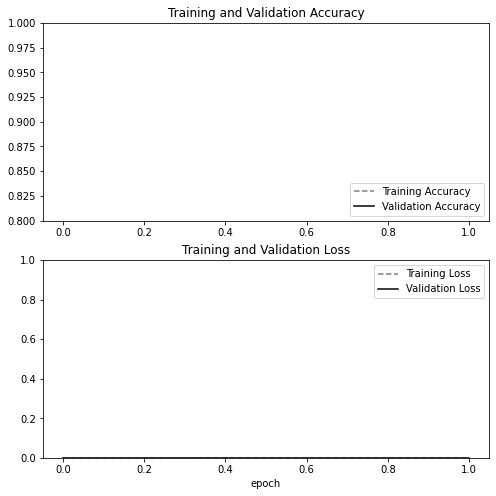

****************************** Test Evaluate ******************************
94/94 [==============================] - 29s 274ms/step - loss: 0.0000e+00 - accuracy: 0.5000 - mse: 0.5000


In [14]:
#train_dataset, validation_dataset, test_dataset = get_dataset()

#Compute number of examples
Example_number = 9800

AIC_list = []
MSE_list = []
Models_parameters_n_list = []
for n in range(1):
  with strategy.scope():
    model = model_(n)
    print(f'****************************** Model n.{n+1} ******************************')
    model_fit = model.fit(train_dataset, epochs=EPOCHS, validation_data=validation_dataset)
    model_fit
    model.summary()

    #Retrieve MSE values for each epoch
    Model_MSE = model_fit.history['mse']
    MSE_list += model_fit.history['mse']

    #Retrieve Parameters numbers for each model
    stringlist = []
    model.summary(line_length=70, print_fn=lambda x: stringlist.append(x))

    substring = 'Trainable params'

    c = 0
    for n in stringlist:
        if substring not in n:
          c += 1
        else:
          break

    substring = stringlist[c]  
    Model_parameters_n = int("".join([i for i in substring if i.isdigit()]))
    Models_parameters_n_list += [Model_parameters_n]

    #Aikaike Information Creterion (AIC) Computation
    for mse_score in Model_MSE:
      AIC_SCORE = [AIC(Example_number, mse_score , Model_parameters_n)]
      AIC_list += AIC_SCORE

    #Show training and validation graphs
    acc = model_fit.history['accuracy']
    val_acc = model_fit.history['val_accuracy']
    loss_ = model_fit.history['loss']
    val_loss_ = model_fit.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy', color = 'gray',linestyle='dashed')
    plt.plot(val_acc, label='Validation Accuracy', color = 'black')
    plt.ylim([0.8, 1])
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss_, label='Training Loss', color = 'gray',linestyle='dashed')
    plt.plot(val_loss_, label='Validation Loss', color = 'black')
    plt.ylim([0, 1.0])
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

    print('****************************** Test Evaluate ******************************')
    model.evaluate(test_dataset)


Show Histoical validation AIC scores graphs

Text(0.5, 1.0, 'Validation AIC')

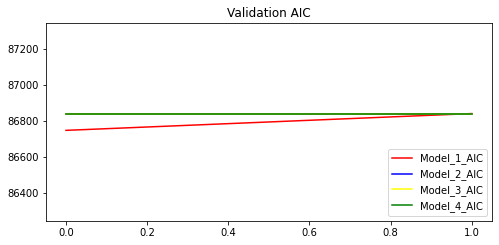

In [22]:
Model_1_AIC = AIC_list[0:EPOCHS]
Model_2_AIC = AIC_list[EPOCHS:EPOCHS*2]
Model_3_AIC = AIC_list[EPOCHS*2:EPOCHS*3]
Model_4_AIC = AIC_list[EPOCHS*3:EPOCHS*4]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(Model_1_AIC, label='Model_1_AIC', color = 'red')
plt.plot(Model_2_AIC, label='Model_2_AIC', color = 'blue')
plt.plot(Model_3_AIC, label='Model_3_AIC', color = 'yellow')
plt.plot(Model_4_AIC, label='Model_4_AIC', color = 'green')
plt.ylim([min(AIC_list)-500, max(AIC_list)+500])
plt.legend(loc='lower right')
plt.title('Validation AIC')

Define Historical Average AIC scores graph

The Best Model is: Normal (Model 1)


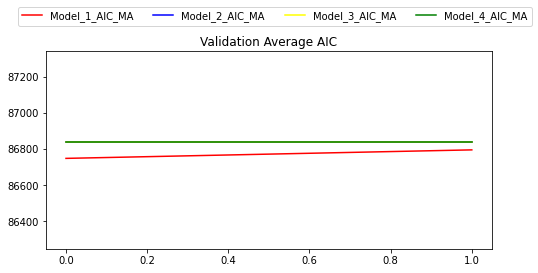

In [23]:
Model_1_AIC_MA = Model_1_AIC
Model_2_AIC_MA = Model_2_AIC
Model_3_AIC_MA = Model_3_AIC
Model_4_AIC_MA = Model_4_AIC

n = 0
for i in Model_1_AIC:
    avg_score_Model_1 = round(sum(Model_1_AIC[:(n+1)])/(n+1))
    avg_score_Model_2 = round(sum(Model_2_AIC[:(n+1)])/(n+1))
    avg_score_Model_3 = round(sum(Model_3_AIC[:(n+1)])/(n+1))
    avg_score_Model_4 = round(sum(Model_4_AIC[:(n+1)])/(n+1))
    Model_1_AIC_MA[n] = avg_score_Model_1
    Model_2_AIC_MA[n] = avg_score_Model_2
    Model_3_AIC_MA[n] = avg_score_Model_3
    Model_4_AIC_MA[n] = avg_score_Model_4
    n = n + 1

lim = Model_1_AIC_MA + Model_2_AIC_MA + Model_3_AIC_MA + Model_4_AIC_MA

Min = min(lim)
Max = max(lim)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(Model_1_AIC_MA, label='Model_1_AIC_MA', color = 'red')
plt.plot(Model_2_AIC_MA, label='Model_2_AIC_MA', color = 'blue')
plt.plot(Model_3_AIC_MA, label='Model_3_AIC_MA', color = 'yellow')
plt.plot(Model_4_AIC_MA, label='Model_4_AIC_MA', color = 'green')
plt.ylim([(Min-500), (Max+500)])
plt.legend(bbox_to_anchor =(1.1, 1.25), ncol = 4)
plt.title('Validation Average AIC')

d = {
  "Normal (Model 1)": Model_1_AIC_MA[len(Model_1_AIC)-1],
  "Dropout (Model 2)": Model_2_AIC_MA[len(Model_2_AIC)-1],
  "L1 Regularization (Model 3)": Model_3_AIC_MA[len(Model_3_AIC)-1],
  "L2 Regularization (Model 4)": Model_4_AIC_MA[len(Model_4_AIC)-1]
}

best_model = min(d, key=d.get)
print(f'The Best Model is: {best_model}')

